In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from scipy.interpolate import BSpline
import numpy as np

class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, num_basis=20, spline_order=3):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_basis = num_basis
        self.order = spline_order

        
        
        initial_knots = []
        for _ in range(in_features):
            base = np.linspace(-2, 2, num_basis + spline_order + 1)
            noise = np.random.uniform(-0.1, 0.1, size=base.shape)
            initial_knots.append(base + noise)

        
        self.knots = nn.Parameter(torch.tensor(initial_knots, dtype=torch.float32))

        
        self.weights = nn.Parameter(torch.randn(out_features, in_features, num_basis))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        B = []
        x = x.float()

        for i in range(self.in_features):
            xi = x[:, i].detach().cpu().numpy()
            knots_i = np.sort(self.knots[i].detach().cpu().numpy())

            bi = []
            for j in range(self.num_basis):
                coeff = np.zeros(self.num_basis)
                coeff[j] = 1
                spline = BSpline(knots_i, coeff, self.order, extrapolate=False)
                val = spline(xi)
                val = np.nan_to_num(val)  
                bi.append(torch.tensor(val, dtype = torch.float32, device=x.device).unsqueeze(-1))
            B.append(torch.cat(bi, dim=1).unsqueeze(1))  

        basis_tensor = torch.cat(B, dim=1)  
        transformed = torch.einsum("bij,kij->bk", basis_tensor, self.weights)
        return transformed + self.bias



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QuantumLCULayer(nn.Module):
    def __init__(self, degree=4):
        super().__init__()
        self.degree = degree
        self.lcu_weights = nn.Parameter(torch.rand(degree))

    def forward(self, qsvt_outputs):  
        N = qsvt_outputs.shape[0]
        quantum_phi_outputs = []
        p_phi_vals = []
        for i in range(N):
            qsvt_vec = qsvt_outputs[i, :]            
            weight_vec = self.lcu_weights            
            phi_val = quantum_lcu_block(qsvt_vec, weight_vec)
            phi_tensor = torch.tensor([phi_val])
            p_phi_vals.append(phi_val)    

        return torch.stack(p_phi_vals).unsqueeze(1)  



In [ ]:
class HybridQuantumKANRegressor(nn.Module):
    def __init__(self, num_basis=10):
        super().__init__()
        self.quantum_layer = QuantumLCULayer(degree=4)
        self.kan_layer = KANLayer(in_features=1, out_features=1, num_basis=30, spline_order=3)

    def forward(self, x):  
        q_out = self.quantum_layer(x)     
        kan_out = self.kan_layer(q_out)   
        return kan_out


In [ ]:
print("X_train device:", X_train.device)
print("y_train device:", y_train.device)


X_train device: cuda:0
y_train device: cuda:0


In [ ]:
import pennylane as qml

class QuantumLCULayer(nn.Module):
    def __init__(self, degree=4, target_polys=None, padded_dim=1024):
        super().__init__()
        self.degree = degree
        self.padded_dim = padded_dim
        self.target_polys = target_polys or [
            [0, 1],
            [-1, 0, 2],
            [0, -3, 0, 4],
            [1, 0, -8, 0, 8]
        ]
        self.lcu_weights = nn.Parameter(torch.rand(degree))
        self.wire_order = list(range(int(np.log2(padded_dim)) + 1))
        self.dev = qml.device("default.qubit", wires=3)

    def quantum_lcu_block(self, qsvt_vals, weight_vals):
        alpha = torch.sqrt(torch.abs(weight_vals) + 1e-8)
        norm = torch.norm(alpha) + 1e-8
        alpha = alpha / norm

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit():
            qml.StatePrep(alpha, wires=[0, 1], pad_with=0.0, normalize=True)

            for r in range(self.degree):
                ctrl_state = [int(b) for b in f"{r:02b}"]
                qml.ctrl(qml.RY, control=[0, 1], control_values=ctrl_state)(2 * qsvt_vals[r], wires=2)
            qml.adjoint(qml.StatePrep(alpha, wires=[0, 1], pad_with=0.0, normalize=True))

            return qml.expval(qml.PauliZ(2))

        return circuit()

    def forward(self, x_vals):  
        N = x_vals.shape[0]
        x_np = x_vals.detach().cpu().numpy()

        f_vals = np.exp(-x_np**2 + 0.3 * x_np) + np.maximum(0, np.tanh(2 * x_np - 1))
        f_vals = f_vals.astype(np.float32).ravel()

        eigvals_padded = np.zeros(self.padded_dim)
        eigvals_padded[:N] = f_vals
        A = np.diag(eigvals_padded)

        qsvt_outputs = []
        for poly in self.target_polys:
            try:
                U_A = qml.matrix(qml.qsvt, wire_order=self.wire_order)(
                    A, poly, encoding_wires=self.wire_order, block_encoding="embedding"
                )
                diag_vals = np.real(np.diagonal(U_A))[:N]
                qsvt_outputs.append(torch.tensor(diag_vals, dtype=torch.float32))
            except Exception as e:
                print(f"QSVT failed for {poly}: {e}")
                qsvt_outputs.append(torch.zeros(N))

        qsvt_stack = torch.stack(qsvt_outputs, dim=1).to(x_vals.device)

        outputs = []
        for i in range(N):
            phi = self.quantum_lcu_block(qsvt_stack[i], self.lcu_weights)
            outputs.append(phi)

        return torch.stack(outputs).unsqueeze(1)  


In [ ]:
X = torch.linspace(-1, 1, 1000).unsqueeze(1)  # Shape: [1000, 1]
y = np.exp(-X**2 + 0.3 * X) + np.maximum(0, np.tanh(2 * X - 1))
y = y.squeeze()

<ipython-input-4-3534433691>:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = np.exp(-X**2 + 0.3 * X) + np.maximum(0, np.tanh(2 * X - 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class HybridQuantumKANRegressor(nn.Module):
    def __init__(self, num_basis=10):
        super().__init__()
        self.quantum_layer = QuantumLCULayer(degree=4)
        self.kan_layer = KANLayer(in_features=1, out_features=1, num_basis=num_basis)

    def forward(self, x):  # x: [N, 4]
        q_out = self.quantum_layer(x)     # shape: [N, 1]
        kan_out = self.kan_layer(q_out)   # shape: [N, 1]
        return kan_out


X_train dtype: torch.float32
weights dtype: torch.float32
knots dtype: torch.float32
Epoch 001 | Train Loss: 0.545152 | Test Loss: 0.418049
Epoch 002 | Train Loss: 0.406633 | Test Loss: 0.302069
Epoch 003 | Train Loss: 0.293561 | Test Loss: 0.211186
Epoch 004 | Train Loss: 0.205579 | Test Loss: 0.144468
Epoch 005 | Train Loss: 0.141711 | Test Loss: 0.100216
Epoch 006 | Train Loss: 0.100206 | Test Loss: 0.075826
Epoch 007 | Train Loss: 0.078400 | Test Loss: 0.067727
Epoch 008 | Train Loss: 0.072659 | Test Loss: 0.071518
Epoch 009 | Train Loss: 0.078518 | Test Loss: 0.082359
Epoch 010 | Train Loss: 0.091079 | Test Loss: 0.095595
Epoch 011 | Train Loss: 0.105650 | Test Loss: 0.107438
Epoch 012 | Train Loss: 0.118426 | Test Loss: 0.115407
Epoch 013 | Train Loss: 0.126937 | Test Loss: 0.118423
Epoch 014 | Train Loss: 0.130130 | Test Loss: 0.116583
Epoch 015 | Train Loss: 0.128141 | Test Loss: 0.110794
Epoch 016 | Train Loss: 0.121926 | Test Loss: 0.102408
Epoch 017 | Train Loss: 0.112882 | 

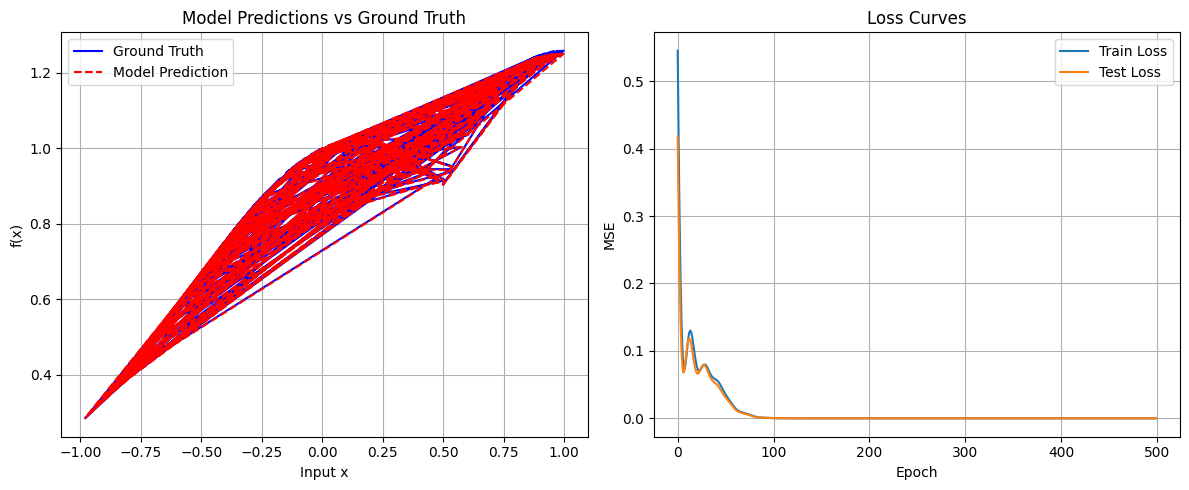

In [ ]:
model = HybridQuantumKANRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_train = X_train.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.float().to(device).view(-1, 1)
y_test = y_test.float().to(device).view(-1, 1)

print("X_train dtype:", X_train.dtype)
print("weights dtype:", model.kan_layer.weights.dtype)
print("knots dtype:", model.kan_layer.knots.dtype)

num_epochs = 500
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss.item():.6f}")

model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    true = y_test.cpu().numpy()
    x_plot = X_test.cpu().numpy().squeeze()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, true, label='Ground Truth', color='blue')
plt.plot(x_plot, preds, label='Model Prediction', color='red', linestyle='--')
plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Input x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


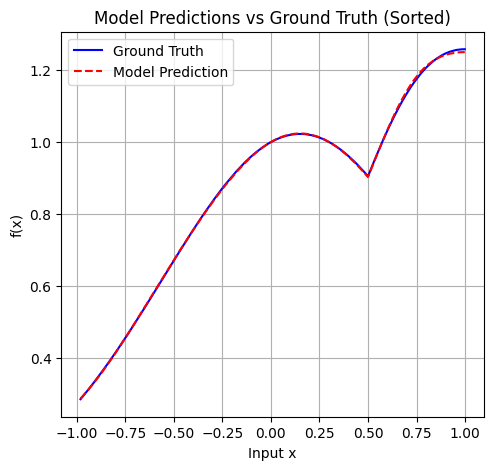

In [ ]:
model.eval()
with torch.no_grad():
  preds = model(X_test).cpu().numpy()
  true = y_test.cpu().numpy()
  x_plot = X_test.cpu().numpy().squeeze()
  sorted_indices = x_plot.argsort()
  x_sorted = x_plot[sorted_indices]
  true_sorted = true[sorted_indices]
  preds_sorted = preds[sorted_indices]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_sorted, true_sorted, label='Ground Truth', color='blue')
plt.plot(x_sorted, preds_sorted, label='Model Prediction', color='red', linestyle='--')
plt.title("Model Predictions vs Ground Truth (Sorted)")
plt.xlabel("Input x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
